<a href="https://colab.research.google.com/github/superbunny38/2021DeepLearning/blob/main/papers/BeautyGlow_On_Demand_Makeup_Transfer_Framework_with_Reversible_Generative_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BeautyGlow: On-Demand Makeup Transfer Framework with Reversible Generative Network.ipynb

source: https://github.com/BeautyGlow/BeautyGlow.github.io

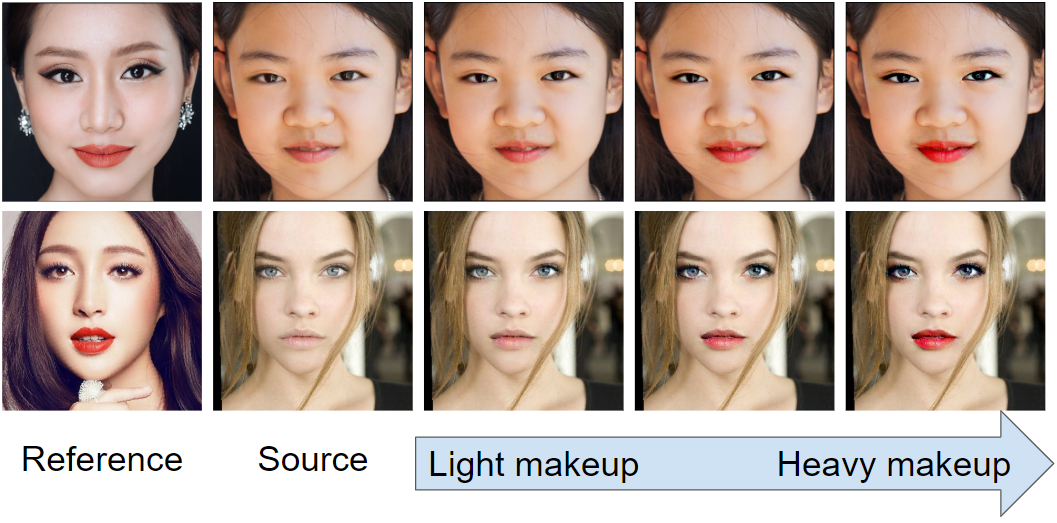

In [ ]:
!pip3 install chainer cupy h5py
!pip3 install tabulate

     |████████████████████████████████| 1.0 MB 8.4 MB/s 
     |████████████████████████████████| 1.7 MB 58.5 MB/s 
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967740 sha256=e655b14d09029c93877197ba6824485b5f06b745b9d6352b88626c070f1e7aeb
  Stored in directory: /root/.cache/pip/wheels/c8/6a/6f/fd563166cc597e5206e375ea074ea836e5db5dd58421215672
y
  Created wheel for cupy: filename=cupy-10.1.0-cp37-cp37m-linux_x86_64.whl size=95182716 sha256=0dad6a7b65377c690fc9ae735769abb7fef7a987c201f6c081b2bdbbe5b01b7a
  Stored in directory: /root/.cache/pip/wheels/b9/90/cb/1c40e3f27621c39a2a90b7297030b9eec35abc5601e68963bc
Successfully built chainer cupy


In [ ]:
%%writefile main.py
import numpy as np
import math
import os
import glob

import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import cupy as cp
import scipy.spatial as sp
from numpy import linalg as LA
import sys

def calculateRMS(x,y):

    error = cp.sqrt(cp.sum((x-y)**2)/2)*2
    return error

file1 = sys.argv[1]
file2 = sys.argv[2]

y = []
latent = []
nomakeup = []
makeup = []
files = []
for e in glob.glob(file1):
    y.append(-1)
    latent.append(np.load(e)[0].ravel())
    nomakeup.append(np.load(e)[0])
nomakeup=np.array(nomakeup)
print(nomakeup.shape)
latent = np.array(latent)
print(latent.shape)
newnomakeup=[]
n=0
for e in glob.glob(file2):
    makeup.append(np.load(e)[0])
    y.append(1)
    n+=1

makeup=np.array(makeup)
c = makeup.shape[1]
width = makeup.shape[2]
height = makeup.shape[3]

makeup = cp.asarray(makeup)
nomakeup = cp.asarray(nomakeup)
makeupim = cp.mean(makeup,axis=0)
nomakeupim = cp.mean(nomakeup, axis=0)
makeupfeature = cp.subtract(makeupim, nomakeupim)
print(makeupim.shape)
nomakeup=cp.reshape(nomakeup,(nomakeup.shape[0],c*width,height))
makeup=cp.reshape(makeup,(makeup.shape[0],c*width,height))
########warp images######


#######Initialize the W########
np.random.seed(42)
mu, sigma = 0, 1
W1 = np.random.normal(mu,sigma,(width, width))
W2 = np.identity(width) - W1
index = np.array([e for e in range(nomakeup.shape[0])])
index_shuffle = np.random.permutation(index)

######prepare model######



l1,l2,l3,l4=0,0,0,0
lr =0.0005
reg_w1 = 0.001
reg_w2 = 0.001

alpha = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8
batch_size = 100
numbatch = math.ceil(len(index_shuffle)/batch_size)
#print(numbatch)
iteration = 10000
total_loss=[]
W1 = cp.asarray(W1)
W2 = cp.asarray(W2)
#print(W1-W2)
W = [W1,W2]

makeupim = cp.reshape(makeupim,(c*width,height))
nomakeupim = cp.reshape(nomakeupim,(c*width,height))
makeupfeature = cp.reshape(makeupfeature,(c*width,height))

file = sys.argv[3]
if not os.path.exists(file):
    os.makedirs(file)


reg_l1 = 1e-2
reg_l3 = 1e-3
reg_l4 = 1e-3
reg_l7 = 0.1
reg_l10 = 1e-2
reg_l8 = 1e+3
reg_l11 = 1e+3
reg_l9 = 1e-1

with open(file+'hyperparam.txt', 'w') as ff:
    for e in [reg_l1,reg_l3, reg_l4, reg_l7, reg_l8, reg_l9, reg_l10, reg_l11]:
        ff.write(str(e))
        ff.write(' ')
for num in range(1,iteration+1):
    grad_w1lr = []
    grad_w2lr = []
    lt = 0
    t = 0

    m_t = [0,0]
    v_t = [0,0]

    nomakeup= shuffle(nomakeup)
    makeup = shuffle(makeup)

    for i in range(numbatch):
        if (i+1)*batch_size >nomakeup.shape[0]:
            start = i * batch_size
            end = nomakeup.shape[0]
            #print(end)
        else:
            start = i*batch_size
            end = (i+1)*batch_size
        dw1 = 0
        dw2 = 0
        #print(start)
        #print(end)
        batchloss=0
        loss_uni = [0, 0, 0, 0, 0, 0]
        for ind in range(start, end):
            d_no = nomakeup[ind]
            d = makeup[ind]

            d_no = cp.asarray(d_no)
            d = cp.asarray(d)

            Pn = cp.dot(d_no, W1)
            Pn_e =  cp.dot(d_no, W1+(1e-5))

            Mn = cp.dot(d_no, W2)
            Mn_e = cp.dot(d_no, W2-(1e-5))

            P = cp.dot(d, W1)
            P_e= cp.dot(d,W1+(1e-5))

            M = cp.dot(d, W2)
            M_e = cp.dot(d,W2-(1e-7))

            d_notom = Pn + M
            d_notom = cp.asarray(d_notom)
            P_notom = cp.dot(d_notom, W1)
            M_notom = cp.dot(d_notom, W2)
            #####calculate loss######

            l1 = calculateRMS(Pn, d_no)
            l3 = calculateRMS(M_notom, M)
            l4 = calculateRMS(P_notom, Pn)
            l7 = calculateRMS(M, makeupfeature)
            l8 = (( 1+cp.sum(cp.multiply(P, makeupim)
                              / (cp.sqrt(cp.sum(cp.power(P.ravel(), 2))) * cp.sqrt(
                            cp.sum(cp.power(makeupim.ravel(), 2))))))**1)
            l9 = calculateRMS(P, nomakeupim)

            l10 = calculateRMS(d_notom, makeupim)
            l11 = (( 1+cp.sum(cp.multiply(d_notom, nomakeupim)
                              / (cp.sqrt(cp.sum(cp.power(d_notom.ravel(), 2))) * cp.sqrt(
                            cp.sum(cp.power(nomakeupim.ravel(), 2))))))**1)

            loss_uni[0] += l11
            loss_uni[1] += l8
            loss_uni[2] += l7
            loss_uni[3] += l9
            loss_uni[4] += l10
            loss = l1 + l3+l4+l7+l8+l9+l10+l11
            #print(loss)
            batchloss += loss


            ####gradient of loss####
            dl1w1 = cp.dot(d_no.T, (Pn-d_no))
            dl3w1 = cp.dot((2*P-2*Pn+d_no-d).T, (M_notom-M))
            #dl3w2 = -cp.dot((2*M + Pn - d).T, (M_notom-M))

            dl4w1 = cp.dot((2*Pn-2*P + d - d_no).T, (P_notom-Pn))


            dl7w1 = cp.dot(-d.T, (M - makeupfeature))
            dl8w1 = cp.dot(d.T, makeupim)/ (cp.sqrt(cp.sum(cp.power(P, 2))) * cp.sqrt(
                            cp.sum(cp.power(makeupim, 2))))
            dl9w1 = cp.dot(d.T, (P - nomakeupim))
            dl10w1 = cp.dot((d_no-d).T, (d_notom - makeupim))
            dl11w1 = cp.dot((-d+d_no).T, nomakeupim) / (cp.sqrt(cp.sum(cp.power(d_notom, 2))) * cp.sqrt(
                cp.sum(cp.power(nomakeupim, 2))))
            dw1 += dl1w1 * reg_l1 + dl3w1*reg_l3 + dl4w1*reg_l4 + dl7w1* reg_l7 + dl10w1*reg_l10  + dl9w1*reg_l9+dl8w1*reg_l8+dl11w1*reg_l11


        dw = [dw1]
        ######Adam optimizer#######

        t +=1
        for j in range(len(dw)):
            m_t[j] = beta_1 * m_t[j] + (1 - beta_1) * dw[j]  # updates the moving averages of the gradient
            v_t[j] = beta_2 * v_t[j] + (1 - beta_2) * (dw[j] * dw[j])  # updates the moving averages of the squared gradient

            m_cap = m_t[j] / (1 - (beta_1 ** t))  # calculates the bias-corrected estimates
            v_cap = v_t[j] / (1 - (beta_2 ** t))  # calculates the bias-corrected estimates

            W[j] = W[j] - (alpha * m_cap) / (cp.sqrt(v_cap) + epsilon)
        W1 = W[0]
        W2 = cp.identity(width) - W1

        lt += batchloss/batch_size

    total_loss.append(lt/numbatch)
    print('Iteration:'+str(num) +' loss: ' + str(lt/numbatch))
    if num % 100 ==0:
        np.save(file+str(num)+'face.npy',cp.asnumpy(W1))
        np.save(file+str(num)+'makeup.npy',cp.asnumpy(W2))
        it = [e for e in range(1, num+1)]
        plt.plot(it, total_loss)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.savefig(file + 'loss.png')



Writing main.py


### train: Glow: Generative Flow with Invertible 1×1 Convolutions

In [ ]:
!git clone https://github.com/musyoku/chainer-glow glow

Cloning into 'glow'...
remote: Enumerating objects: 1354, done.
remote: Total 1354 (delta 0), reused 0 (delta 0), pack-reused 1354
Receiving objects: 100% (1354/1354), 503.44 KiB | 12.91 MiB/s, done.
Resolving deltas: 100% (648/648), done.


In [ ]:
%cd glow

/content/glow


In [ ]:
!mkdir train_dataset

need to convert image to png files